Changes: 
- L = int(N * SIZEFACTOR)
- instead of rand_state=#, I added a var cand_seed before np.random.state(#). cand_seed is incremented by 1 each time a new set of candidates are calculated!
- print STARTTEMP, TEMPFACTOR, L, MINPERCENT, COMP_DEV before running simanneal block
- import time, add calc_time function at beginning of Staple Functions, add time.time() before/after simanneal block, calc_time right after end = time.time()
- commented out save to csv
- add print outs for frozen_count, fc increment, and fc reset
- add print outs for increments in header
- increase header length for each "simulated annealing run" printout
- add compactness calcs
- add save for x,y scatterplot as a dataframe
- mean(), min() in fancy compact into np.mean(), np.min() [wait.... was numpy even imported???] -- import numpy as np
- edit frozen cut-off

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import time
import numpy as np

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
DRIVE_PATH = "/Users/carolyn/Drive/quantgerry/"
def full_path(filename):
    return DRIVE_PATH + filename

### Preprocessing, Initializing Variables, etc.

In [4]:
#dist_VTD_path = full_path("acr_VTD.txt")
#dist_shp_path = full_path('acr_shapefiles')
dist_VTD_path = full_path("code_data_NC_NCAbs_2016.txt")
dist_shp_path = full_path('2016_NC_shapefiles_updated')

In [5]:
#Combine today's datasets
df2 = gpd.read_file(full_path('NCabs_VTD'))
pairings = pd.read_csv(dist_VTD_path, sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})

### Grab Comparator District

In [6]:
def get_comparators(orig_filepath, rank_num):
    #Initialize original district stats
    orig = pd.read_csv(orig_filepath, sep='\t', header=None)
    orig["sample_num"] = -1

    #Grab election data from main df2 DataFrame
    election_data = df2.loc[:, ['VTD_num', "EL16G_PR_D", 'EL16G_PR_R', 'EL16G_PR_T']]

    #Grab a list of compliant numbers
    compliant = pd.read_csv(full_path("ensembles_main_rank_" + str(rank_num) + "_compliantVerbose.txt"), sep='\t', header=None)
    compliant.rename(columns={0:"sample_num", 1:"is_compliant"}, inplace=True)
    compliant_nums = compliant[compliant.is_compliant==1].sample_num.tolist()

    #Takes about 5 seconds
    #Iterate through all the compliant samples and read in their data
    pd_lists = []
    for sample_num in compliant_nums:
        filepath = full_path("ensembles_main_rank_" + str(rank_num) 
                             + "_districtingMaps/districtingMap") + str(sample_num) + ".txt"
        new = pd.read_csv(filepath, sep='\t', header=None)
        new["sample_num"] = sample_num
        pd_lists.append(new)
    pd_lists.append(orig)

    #Concat and rename
    final = pd.concat(pd_lists)
    final.rename(columns={0:"VTD_num", 1:"district"}, inplace=True)

    #Join with election data
    final = final.merge(election_data, how='left', on="VTD_num")

    #Group at district level
    grouped = final.groupby(["sample_num", "district"]).sum()

    #Grouped at the district level, calculate district-level stats like dem prop and rep prop
    grouped["dem_prop"] = grouped["EL16G_PR_D"]/grouped["EL16G_PR_T"]
    grouped['rep_prop'] = grouped["EL16G_PR_R"]/grouped["EL16G_PR_T"]
    grouped['dem_win'] = 0
    grouped.loc[grouped.dem_prop > grouped.rep_prop, "dem_win"] = 1
    grouped.drop(columns=['EL16G_PR_D', 'EL16G_PR_R', 'EL16G_PR_T', 'VTD_num'], inplace=True)

    flattened = grouped.reset_index()

    #Add district-level stats to each VTD
    final2 = final.merge(flattened, how="left", left_on=['sample_num', 'district'], right_on=['sample_num', 'district'])

    orig_dst_lvl = final2.loc[final2.sample_num==-1]
    comp_dst_lvl = final2.loc[final2.sample_num!=-1]

    #Add original districting data to each comparator VTD entry — for easy calculation of differences between comparator
    final3 = comp_dst_lvl.merge(orig_dst_lvl, how="left", left_on='VTD_num', right_on='VTD_num', suffixes=('', '_orig'))
    
    #Actually, we do want orig to be labeled with column names! Since we use it later
    orig.rename(columns={0:"VTD_num", 1:"district"}, inplace=True)
    
    return final3, orig

In [7]:
#Why do we even need orig?
final3, orig = get_comparators(orig_filepath = dist_VTD_path, rank_num=0)

### Staple Functions

In [8]:
def calc_time(start, end):
    seconds = end - start
    mins = seconds / 60
    print('Time:', str(seconds), '    ', str(mins))
    return seconds, mins

In [9]:
def dist_level_data(VTD_data):
    districts = VTD_data.groupby('district')[['EL16G_PR_D', 'EL16G_PR_R', 'EL16G_PR_T', 'TOTPOP']].sum().reset_index()
    districts['dem_prop'] = districts.EL16G_PR_D/districts.EL16G_PR_T
    districts['rep_prop'] = districts.EL16G_PR_R/districts.EL16G_PR_T
    return districts

In [10]:
# Calculate the Polsby Popper compactness score
def polsby_popper(shape):
    return (4 * np.pi * shape.area) / (shape.length ** 2)

In [11]:
def calc_gmandered_score(df):
    dem_filter = ((df.dem_prop > df.rep_prop) & (df.dem_prop_orig < df.rep_prop_orig)) | (((df.dem_prop_orig - df.dem_prop) > PK_PCT) & (df.dem_prop > df.rep_prop))
    rep_filter = ((df.rep_prop > df.dem_prop) & (df.rep_prop_orig < df.dem_prop_orig)) | (((df.rep_prop_orig - df.rep_prop) > PK_PCT) & (df.rep_prop > df.dem_prop))


    df['dem_gmandered'] = np.where(dem_filter, df['EL16G_PR_D'], 0)
    df['rep_gmandered'] = np.where(rep_filter, df['EL16G_PR_R'], 0)
    df['tot_gmandered'] = df.dem_gmandered + df.rep_gmandered
    
    #Summing up in total and dividing by sample num is the same as grouping by and taking mean.
    return df.tot_gmandered.sum()/NUM_SAMPLE_NUM

In [12]:
def calc_candidates(curr_data):
    curr_data[("neighborof")] = 0
    for district in range(1, 14):
        dist_comp = curr_data.loc[curr_data.district==district, "loc_prec"].tolist()
        neighbors = set()
        neighbor_list = curr_data.loc[curr_data.district==district, "neighbors"].tolist()
        for one_neighbor_list in neighbor_list:
            for item2 in one_neighbor_list:
                neighbors.add(item2)
        neighbors = neighbors.difference(dist_comp)
        curr_data.loc[curr_data.loc_prec.isin(neighbors), "neighborof"] = district
    candidates = curr_data[curr_data.neighborof!=0]
    return candidates

In [13]:
def check_compact(orig_shapes, row, COMP_DEV, remove_shape, add_shape):
    dist_comp = polsby_popper(orig_shapes.loc[row.district, 'geometry'])
    neigh_comp = polsby_popper(orig_shapes.loc[int(row.neighborof),'geometry'])
    remove_comp = polsby_popper(remove_shape)
    add_comp = polsby_popper(add_shape)
    remove_dev = (dist_comp - remove_comp) / dist_comp #pos when new worse than orig
    add_dev = (neigh_comp - add_comp) / neigh_comp #pos when new worse than orig

    #print("Compactness deviations of:", remove_dev, add_dev)
    if ((remove_dev >= COMP_DEV) or (add_dev >= COMP_DEV)):
        #print("Compactness check failed!", remove_dev, add_dev)
        return False
    else:
        #print("Compactness check passed")
        return True

In [14]:
def check_fancy_compact(orig_pols_list, temp_pols_list, row, COMP_DEV, remove_shape, add_shape):
    remove_comp = polsby_popper(remove_shape)
    add_comp = polsby_popper(add_shape)
    temp_pols_list[row.neighborof-1] = add_comp #lists index from 0
    temp_pols_list[row.district-1] = remove_comp
    
    avg_dev = (np.mean(orig_pols_list) - np.mean(temp_pols_list))/np.mean(orig_pols_list) #pos when temp worse than orig
    worst_dev = (np.min(orig_pols_list) - np.min(temp_pols_list))/np.min(orig_pols_list) #pos when temp worse than orig
    
    if ((avg_dev >= COMP_DEV) or (worst_dev >= COMP_DEV)): #if positively deviates more than comp_dev
        return False
    else:
        return True

### Run Algo

Data Needed: data, shapes, districts (dist-lvl data), scoredf

In [15]:
### STATE-SPECIFIC or unchanging CONSTANTS
NUM_DIST = 13 # Number of districts
IDEAL_POP = 733499 # Ideal population per district
PK_PCT = 0.05 # Amount of change necessary to cross packedness threshold in calc_gmandered_score_fast()
NUM_SAMPLE_NUM = final3.sample_num.nunique()

In [16]:
### Implementation variables
POP_DEV = 0.02 # Amount of acceptable population deviation
COMP_DEV = 0.05 # Amount of acceptable compactness deviation
N = 711 #Neighborhood size

In [17]:
#Initialize orig_data and orig_shapes
orig_data = df2.merge(pairings, on='VTD_num')
orig_data["neighbors"] = orig_data.my_neighbo.str.split(", ")
orig_data = orig_data[['VTD_num', 'EL16G_PR_D', 'EL16G_PR_R', 'EL16G_PR_T', 'TOTPOP', 'neighbors', 'district', 'loc_prec', 'geometry']]
orig_shapes = gpd.read_file(dist_shp_path)
if 'District' in orig_shapes.columns:
    orig_shapes.rename(columns={'District':'district'}, inplace=True)
orig_shapes.index = orig_shapes.district #The index is the exact district numbers
orig_pols_list = polsby_popper(orig_shapes).tolist()

In [18]:
#RERUN THIS TO FULLY RESTART ALGORITHM
# Initialize simulated annealing variables used in the algorithm
cand_seed = 0
champ_scoredf = None
champ_data = None

orig_districts = dist_level_data(orig_data)

curr_shapes = orig_shapes.copy()
curr_scoredf = final3.copy()
#Cull the scoredf to only contain the columns we need! The copy operations will be costly otherwise
curr_scoredf = curr_scoredf[['dem_prop', 'rep_prop', 'dem_prop_orig', 'rep_prop_orig', 
                             'VTD_num', 'EL16G_PR_D', 'EL16G_PR_R', 'district_orig']]
champ_scoredf = curr_scoredf
curr_districts = orig_districts.copy()
curr_data = orig_data.copy()

count = 0
x = []
y = []

In [19]:
start = time.time()

In [20]:
#Can pause this code block and continue later with your progress saved!
while True:
    curr_iter_district = -1 
    curr_iter_neighborof = -1 
    curr_iter_gmandered = -1 
    update_slice = True
    cand_seed += 1
    count += 1
    if count % 25 == 0:
        score = calc_gmandered_score(curr_scoredf)
        x.append(count)
        y.append(score)

    print("============ Recalculating candidates", count, "============")
    candidates = calc_candidates(curr_data)
    
    found_swap = False
    nonpop = 0
    noncontig = 0
    noncompact = 0
    nongerry = 0
    
    for index, row in candidates.sample(frac=1, random_state=cand_seed).iterrows():    
        #Population check
        if ((curr_districts.loc[curr_districts.district == row.district, 'TOTPOP'].iloc[0] - row.TOTPOP) > (IDEAL_POP*(1-POP_DEV))) & (
            (curr_districts.loc[curr_districts.district == row.neighborof, 'TOTPOP'].iloc[0] + row.TOTPOP) < (IDEAL_POP*(1+POP_DEV))):
            pass
        else:
            nonpop += 1
            continue
        
        #Determine whether to update the curr_df_slice (timesaving device)
        if (row.district != curr_iter_district) | (row.neighborof != curr_iter_neighborof) | (
            curr_iter_gmandered == -1):
            update_slice = True
            curr_iter_district = row.district
            curr_iter_neighborof = row.neighborof
            

        ### Check contiguity
        prec_shape = df2.loc[df2.loc_prec==row.loc_prec, 'geometry'].values[0]
        remove_shape = curr_shapes.loc[row.district, 'geometry'].difference(prec_shape)
        add_shape = curr_shapes.loc[int(row.neighborof), 'geometry'].union(prec_shape)

        if ((remove_shape.geom_type != 'Polygon') or (len(remove_shape.interiors) > 0)) or ((add_shape.geom_type != 'Polygon') or (len(add_shape.interiors) > 0)):
            #print("Contiguity check failed! Select new VTD to test.")
            noncontig += 1
            continue
        else:
            #print("Contiguity check passed!")
            pass

        ### Check compactness
        temp_pols_list = polsby_popper(curr_shapes).tolist()
        if check_fancy_compact(orig_pols_list, temp_pols_list, row, COMP_DEV, remove_shape, add_shape)==False:
            noncompact += 1
            continue
        else:
            pass
        

        #=======Calc the current level of gerrymandering======
        if update_slice:
            curr_scoredf_slice = curr_scoredf.loc[(curr_scoredf.district_orig==row.district)|(curr_scoredf.district_orig==row.neighborof)]
            curr_iter_gmandered = calc_gmandered_score(curr_scoredf_slice)
            update_slice = False

        #Perform the swap in data
        temp_data = curr_data.copy()
        temp_data.loc[temp_data.VTD_num == row.VTD_num, 'district'] = row.neighborof
        temp_districts = dist_level_data(temp_data)

        #Two cases
        #1. If dist/neighborof changes, then curr has just been updated. 
        #2. If dist/neighborof hasn't changed, curr_scoredf_slice will still be good from last iteration
        temp_scoredf_slice = curr_scoredf_slice.copy()

        #Perform the swap in the scoredf
        temp_scoredf_slice.loc[temp_scoredf_slice.VTD_num == row.VTD_num, 'district_orig'] = row.neighborof
        temp_scoredf_slice.loc[(temp_scoredf_slice.district_orig==row.neighborof),['dem_prop_orig', 'rep_prop_orig']] = temp_districts.loc[(temp_districts.district==row.neighborof), ['dem_prop', 'rep_prop']].iloc[0].tolist()
        temp_scoredf_slice.loc[(temp_scoredf_slice.district_orig==row.district),['dem_prop_orig', 'rep_prop_orig']] = temp_districts.loc[(temp_districts.district==row.district), ['dem_prop', 'rep_prop']].iloc[0].tolist()

        temp_gmandered = calc_gmandered_score(temp_scoredf_slice)

        if temp_gmandered < curr_iter_gmandered:
            print('good swap')
            swap = True
        elif temp_gmandered == curr_iter_gmandered:
            #Don't let zero cost swaps occur, they just repeat over and over
            nongerry += 1
            swap = False
        else:
            print('bad swap')
            nongerry += 1
            swap = False
        
        if swap == True:      
            found_swap=True
            print("swap", row.loc_prec, "VTD from", row.district, "to", row.neighborof, "base", curr_iter_gmandered, 'new', temp_gmandered)
            curr_shapes.loc[row.district, 'geometry'] = remove_shape
            curr_shapes.loc[row.neighborof, 'geometry'] = add_shape
            curr_districts = temp_districts
            curr_data = temp_data
            curr_scoredf.loc[curr_scoredf.VTD_num == row.VTD_num, 'district_orig'] = row.neighborof
            curr_scoredf.loc[(curr_scoredf.district_orig==row.neighborof),['dem_prop_orig', 'rep_prop_orig']] = temp_districts.loc[(temp_districts.district==row.neighborof), ['dem_prop', 'rep_prop']].iloc[0].tolist()
            curr_scoredf.loc[(curr_scoredf.district_orig==row.district),['dem_prop_orig', 'rep_prop_orig']] = temp_districts.loc[(temp_districts.district==row.district), ['dem_prop', 'rep_prop']].iloc[0].tolist()
            break #Break to recalculate candidates
    print('Number of failed population checks:', nonpop)
    print('Number of failed contiguity checks:', noncontig)
    print('Number of failed compactness checks:', noncompact)
    print('Number of failed gmandered score checks:', nongerry)
    print()
    if found_swap==False:
        print("No swaps could be made! End.")
        break

============ Recalculating candidates 1 ============
good swap
swap 3718318-03 VTD from 2 to 4 base 390483.0407582938 new 389605.74597156397
Number of failed population checks: 0
Number of failed contiguity checks: 0
Number of failed compactness checks: 0
Number of failed gmandered score checks: 0

============ Recalculating candidates 2 ============
good swap
swap 3718314-01 VTD from 2 to 1 base 302735.6947867299 new 301268.95165876776
Number of failed population checks: 0
Number of failed contiguity checks: 0
Number of failed compactness checks: 1
Number of failed gmandered score checks: 0

============ Recalculating candidates 3 ============
bad swap
good swap
swap 3718306-06 VTD from 2 to 4 base 389385.4293838863 new 387710.0786729858
Number of failed population checks: 0
Number of failed contiguity checks: 0
Number of failed compactness checks: 0
Number of failed gmandered score checks: 1

============ Recalculating candidates 4 ============
good swap
swap 37021102.1 VTD from 10 t

good swap
swap 37017P25 VTD from 9 to 7 base 80114.21990521326 new 79959.67772511848
Number of failed population checks: 0
Number of failed contiguity checks: 0
Number of failed compactness checks: 2
Number of failed gmandered score checks: 0

============ Recalculating candidates 29 ============
good swap
swap 37067073 VTD from 5 to 13 base 80955.70236966824 new 80838.89478672986
Number of failed population checks: 0
Number of failed contiguity checks: 0
Number of failed compactness checks: 0
Number of failed gmandered score checks: 0

============ Recalculating candidates 30 ============
good swap
swap 3702155.1 VTD from 10 to 11 base 64804.59146919431 new 63250.083412322274
Number of failed population checks: 0
Number of failed contiguity checks: 0
Number of failed compactness checks: 5
Number of failed gmandered score checks: 0

============ Recalculating candidates 31 ============
bad swap
good swap
swap 370230018 VTD from 11 to 5 base 71980.52322274882 new 71930.3355450237
Number

good swap
swap 37195PRWH VTD from 1 to 2 base 277002.4208530806 new 276250.7203791469
Number of failed population checks: 1
Number of failed contiguity checks: 0
Number of failed compactness checks: 2
Number of failed gmandered score checks: 0

============ Recalculating candidates 56 ============
good swap
swap 37027PR28 VTD from 11 to 5 base 71003.84170616114 new 66140.79526066351
Number of failed population checks: 4
Number of failed contiguity checks: 2
Number of failed compactness checks: 15
Number of failed gmandered score checks: 0

============ Recalculating candidates 57 ============
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
good swap
swap 37119144 VTD from 9 to 12 base 192635.39620853082 new 191855.28909952607
Number of failed population checks: 6
Number of failed contiguity checks: 2
Number of failed compactness checks: 19
Number of failed gmandered score checks: 6

============ Recalculating candidates 58 ============
bad swap
bad swap
bad swap
bad swap
good swa

bad swap
bad swap
good swap
swap 370230029 VTD from 11 to 10 base 34235.18862559242 new 33743.58104265403
Number of failed population checks: 8
Number of failed contiguity checks: 0
Number of failed compactness checks: 3
Number of failed gmandered score checks: 2

============ Recalculating candidates 82 ============
bad swap
bad swap
bad swap
bad swap
good swap
swap 3706912 VTD from 2 to 1 base 267441.7763033175 new 266614.3526066351
Number of failed population checks: 31
Number of failed contiguity checks: 1
Number of failed compactness checks: 45
Number of failed gmandered score checks: 4

============ Recalculating candidates 83 ============
good swap
swap 37003S2 VTD from 5 to 13 base 83060.96966824644 new 82484.09573459715
Number of failed population checks: 2
Number of failed contiguity checks: 1
Number of failed compactness checks: 5
Number of failed gmandered score checks: 0

============ Recalculating candidates 84 ============
bad swap
bad swap
good swap
swap 371471512A VTD 

Number of failed population checks: 0
Number of failed contiguity checks: 1
Number of failed compactness checks: 0
Number of failed gmandered score checks: 1

============ Recalculating candidates 108 ============
good swap
swap 37145ALVI VTD from 6 to 1 base 220728.5962085308 new 219013.77819905215
Number of failed population checks: 3
Number of failed contiguity checks: 2
Number of failed compactness checks: 1
Number of failed gmandered score checks: 0

============ Recalculating candidates 109 ============
bad swap
good swap
swap 371471102A VTD from 3 to 1 base 150501.96208530807 new 150174.78009478672
Number of failed population checks: 1
Number of failed contiguity checks: 0
Number of failed compactness checks: 3
Number of failed gmandered score checks: 1

============ Recalculating candidates 110 ============
bad swap
good swap
swap 37145HLWY VTD from 6 to 1 base 218850.01706161138 new 216866.70521327015
Number of failed population checks: 15
Number of failed contiguity checks: 1

bad swap
bad swap
bad swap
bad swap
bad swap
good swap
swap 371471510A VTD from 3 to 1 base 139054.15829383887 new 138679.98483412323
Number of failed population checks: 12
Number of failed contiguity checks: 4
Number of failed compactness checks: 23
Number of failed gmandered score checks: 5

============ Recalculating candidates 133 ============
bad swap
bad swap
bad swap
bad swap
bad swap
good swap
swap 37119032 VTD from 9 to 12 base 182886.02938388626 new 182437.4
Number of failed population checks: 15
Number of failed contiguity checks: 2
Number of failed compactness checks: 32
Number of failed gmandered score checks: 5

============ Recalculating candidates 134 ============
good swap
swap 37125PBF VTD from 8 to 9 base 102769.41611374408 new 102747.15639810427
Number of failed population checks: 2
Number of failed contiguity checks: 0
Number of failed compactness checks: 1
Number of failed gmandered score checks: 0

============ Recalculating candidates 135 ============
bad swap
b

good swap
swap 3709304 VTD from 8 to 9 base 101155.58009478672 new 101095.4018957346
Number of failed population checks: 3
Number of failed contiguity checks: 0
Number of failed compactness checks: 2
Number of failed gmandered score checks: 0

============ Recalculating candidates 158 ============
bad swap
good swap
swap 37081FR3 VTD from 6 to 13 base 165266.63696682465 new 165203.97914691942
Number of failed population checks: 7
Number of failed contiguity checks: 4
Number of failed compactness checks: 10
Number of failed gmandered score checks: 1

============ Recalculating candidates 159 ============
bad swap
bad swap
good swap
swap 37119058 VTD from 9 to 12 base 173519.0521327014 new 172759.1279620853
Number of failed population checks: 17
Number of failed contiguity checks: 3
Number of failed compactness checks: 33
Number of failed gmandered score checks: 2

============ Recalculating candidates 160 ============
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad sw

bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
good swap
swap 3715931 VTD from 13 to 8 base 111001.29289099526 new 110959.81990521327
Number of failed population checks: 45
Number of failed contiguity checks: 4
Number of failed compactness checks: 51
Number of failed gmandered score checks: 6

============ Recalculating candidates 182 ============
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
good swap
swap 37143BELVID VTD from 3 to 1 base 136324.34976303318 new 135954.58767772513
Number of failed population checks: 39
Number of failed contiguity checks: 4
Number of failed compactness checks: 29
Number of failed gmandered score checks: 15

============ Recalculating candidates 183 ============
bad swap
good swap
swap 37027PR23 VTD from 11 to 5 base 30340.61421800948 new 30073.363981042654
Number of failed population checks: 9
Number of failed contiguity checks: 0
Number of failed compactness

bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
good swap
swap 37119221 VTD from 9 to 12 base 165040.8739336493 new 164355.24834123222
Number of failed population checks: 36
Number of failed contiguity checks: 3
Number of failed compactness checks: 36
Number of failed gmandered score checks: 14

============ Recalculating candidates 207 ============
bad swap
good swap
swap 37051CC34 VTD from 9 to 8 base 98892.91469194312 new 98864.65213270142
Number of failed population checks: 2
Number of failed contiguity checks: 0
Number of failed compactness checks: 1
Number of failed gmandered score checks: 1

============ Recalculating candidates 208 ============
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
good swap
swap 3702502-07 VTD from 8 to 12 base 176658.18388625592 new 175999.44075829384
Number of failed population checks: 24
Number

bad swap
bad swap
bad swap
good swap
swap 37081G29 VTD from 6 to 13 base 160801.68436018957 new 160773.70521327015
Number of failed population checks: 1
Number of failed contiguity checks: 0
Number of failed compactness checks: 8
Number of failed gmandered score checks: 3

============ Recalculating candidates 229 ============
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
good swap
swap 37081G73 VTD from 13 to 6 base 160773.70521327015 new 160220.08056872038
Number of failed population checks: 121
Number of failed contiguity checks: 10
Number of failed compactness checks: 154
Number of failed gmandered score checks: 25

============ Recalculating candidates 230 ============
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
bad swap
good swap
sw

In [21]:
end = time.time()

In [22]:
seconds, mins = calc_time(start, end)

Time: 329.7885990142822      5.496476650238037


In [23]:
current_min = 0
current_min = current_min + mins

In [24]:
current_min

5.496476650238037

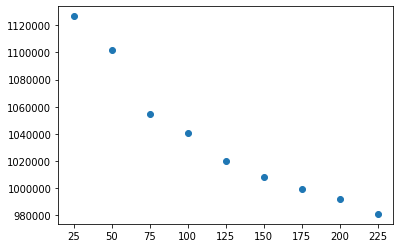

In [25]:
plt.scatter(x, y)

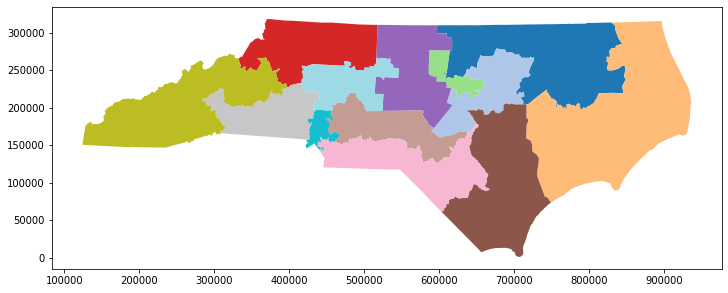

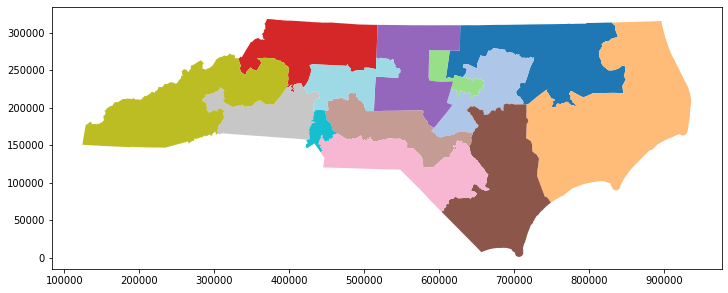

In [26]:
curr_shapes.plot(figsize=(12, 10), column='district', cmap='tab20')
orig_shapes.plot(figsize=(12, 10), column='district', cmap='tab20')

In [27]:
calc_gmandered_score(curr_scoredf)

977004.1668246445

In [28]:
#orig_scoredf = final3.copy() Commented out whne doing timeit func.
calc_gmandered_score(final3)

1151027.4312796209

In [29]:
curr_comp = curr_data.dissolve(by='district', as_index=False)
curr_comp['polsby'] = polsby_popper(curr_comp['geometry'])
mean = curr_comp['polsby'].mean()
least = curr_comp['polsby'].min()
print(mean, least)

0.235409094324659 0.15271664759361647


In [30]:
orig_comp = orig_data.dissolve(by='district', as_index=False)
orig_comp['polsby'] = polsby_popper(orig_comp['geometry'])
orig_mean = orig_comp['polsby'].mean()
orig_lease = orig_comp['polsby'].min()
print(orig_mean, orig_lease)

0.24775490807547768 0.15691803803529356


### Plot dist partisanness

In [31]:
def plot_dist_partisaness(curr_districts, curr_dist_shapes):
    #Expensive operation
    curr_dist_shapes["rep_prop"] = curr_districts['rep_prop'].round(3).values
    curr_dist_shapes['coords'] = curr_dist_shapes['geometry'].apply(lambda x: x.representative_point().coords[:])
    curr_dist_shapes['coords'] = [coords[0] for coords in curr_dist_shapes['coords']]
    curr_dist_shapes.plot(figsize=(18, 16),
               column="rep_prop", cmap="coolwarm", legend=True, vmin=0, vmax=1, edgecolor="black", legend_kwds={'shrink': 0.3})
    plt.title("Rep Vote Percentage Per District")
    for idx, row in curr_dist_shapes.iterrows():
        plt.annotate(s=row['district'], xy=row['coords'],
                     horizontalalignment='center')
    #print(calc_eff_gap(finaldf))

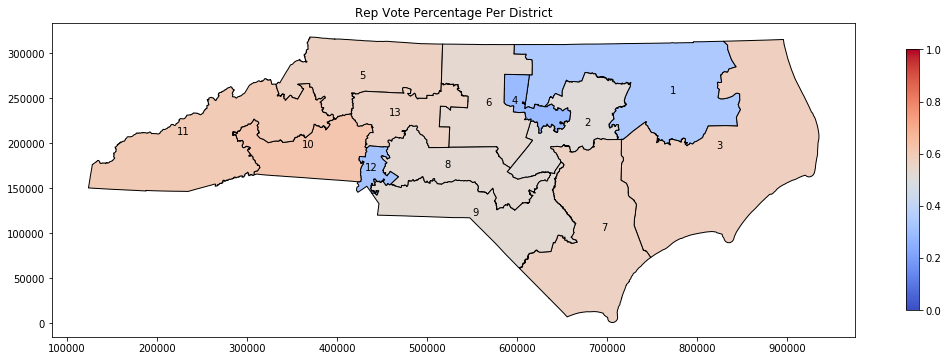

In [32]:
plot_dist_partisaness(curr_districts, curr_shapes)

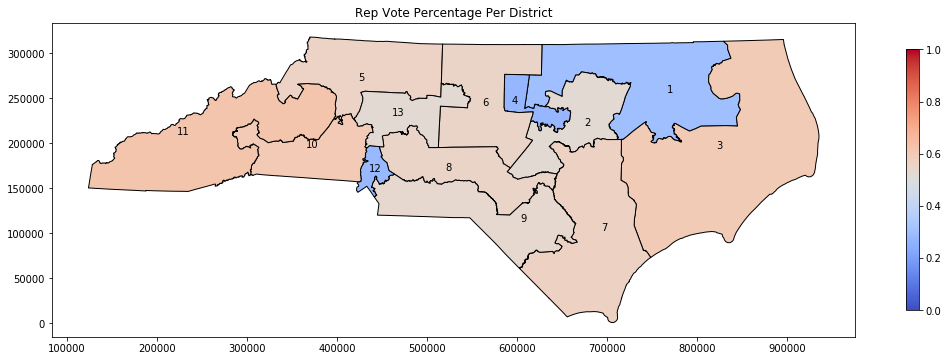

In [33]:
plot_dist_partisaness(orig_districts, orig_shapes)

### Save Output to check in Justified Chain

In [34]:
curr_data[['VTD_num', 'district']].to_csv(full_path('stochastic/test1.3.txt'), sep='\t', header=False, index=False)

In [35]:
d = {'x':x, 'y': y}
x_y_dataframe = pd.DataFrame(d)
x_y_dataframe.to_csv(full_path('stochastic/test1.3_xy.txt'), sep='\t', header=False, index=False)